In [1]:
import numpy as np
import pandas as pd

In [4]:
df1 = pd.read_excel('../bee_trajectory_data/TrackData_2021-06-09_Yellow 8.xlsx')

In [5]:
df1

,All3DInd,Camera1DataInd,Camera2DataInd,Index_TrackFileData,TrackFilePath_Processed,MaleID,ID_No,Log_Array_Name,Array_Name,Array_Code,...,Closest_Location_Code,Closest_Location_Type,Movement_Name,Movement_Code,Behaviour_Name,Behaviour_Code,Segment_No,Visit_No,Patrol_No,LandingVisit
0,1,219,219,6,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,5,2,Walking,3.0,Unknown,1.0,1.0,NaN,NaN,0
1,2,220,220,6,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,5,2,Walking,3.0,Unknown,1.0,1.0,NaN,NaN,0
2,3,221,221,6,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,5,2,Walking,3.0,Unknown,1.0,1.0,NaN,NaN,0
3,4,222,222,6,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,5,2,Walking,3.0,Unknown,1.0,1.0,NaN,NaN,0
4,5,223,223,6,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,5,2,Walking,3.0,Unknown,1.0,1.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191924,14487,112917,112917,10,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,10,1,Flying,2.0,Unknown,1.0,12601.0,NaN,NaN,0
191925,14488,112918,112918,10,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,10,1,Flying,2.0,Unknown,1.0,12601.0,NaN,NaN,0
191926,14489,112919,112919,10,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,10,1,Flying,2.0,Unknown,1.0,12601.0,NaN,NaN,0
191927,14490,112920,112920,10,D:\Dropbox\Google drive\QMUL\Natacha Rossi\210...,Yellow 8,2,6 feeders/6 branches (random),Random array,1,...,10,1,Flying,2.0,Unknown,1.0,12601.0,NaN,NaN,0


## extract relevant column

In [6]:
# Step 1: Extract relevant columns
relevant_df = df1[['time', 'x', 'y', 'z']].copy()

# Step 2: Check for missing values
print(relevant_df.isna().sum())

# Step 3: Show the first few rows to confirm
print(relevant_df.head())

time    0
x       0
y       0
z       0
dtype: int64
    time       x       y     z
0  7.270  1478.8  1998.5 -66.6
1  7.303  1476.6  2000.5 -66.3
2  7.336  1475.3  2001.8 -66.1
3  7.370  1474.6  2002.5 -66.4
4  7.403  1473.7  2003.2 -67.0


In [7]:
# Step 1: Calculate time difference between rows
relevant_df['time_diff'] = relevant_df['time'].diff()

# Step 2: Mark where a gap occurs
MAX_TIME_GAP = 0.2
relevant_df['gap'] = relevant_df['time_diff'] > MAX_TIME_GAP

# Step 3: Assign segment IDs
segment_id = 0
segment_ids = []

for is_gap in relevant_df['gap'].fillna(False):
    if is_gap:
        segment_id += 1
    segment_ids.append(segment_id)

relevant_df['segment'] = segment_ids

# Step 4: Preview segment counts
print("Number of segments:", relevant_df['segment'].nunique())
print(relevant_df[['time', 'time_diff', 'gap', 'segment']].head(10))

Number of segments: 1366
    time  time_diff    gap  segment
0  7.270        NaN  False        0
1  7.303      0.033  False        0
2  7.336      0.033  False        0
3  7.370      0.034  False        0
4  7.403      0.033  False        0
5  7.436      0.033  False        0
6  7.470      0.034  False        0
7  7.503      0.033  False        0
8  7.536      0.033  False        0
9  7.570      0.034  False        0


## interpolating 

In [8]:
interpolated_segments = []

for seg_id, segment in relevant_df.groupby('segment'):
    segment = segment[['time', 'x', 'y', 'z']].set_index('time')
    
    if len(segment) < 2:
        continue  # Skip if segment is too short
    
    start, end = segment.index[0], segment.index[-1]
    new_times = np.arange(start, end, 0.033)  # ~30 fps
    
    # Reindex to uniform times
    reindexed = segment.reindex(new_times)
    
    # Save before interpolation (to compare)
    reindexed_before = reindexed.copy()
    
    # Interpolate missing values linearly
    interpolated = reindexed.interpolate(method='linear', limit_direction='both')
    
    # Restore time column and reset index
    interpolated['time'] = interpolated.index
    interpolated.reset_index(drop=True, inplace=True)
    
    interpolated_segments.append({
        'segment_id': seg_id,
        'before': reindexed_before,
        'after': interpolated
    })

In [9]:
# Pick a random segment (you can change the index)
sample = interpolated_segments[0]

print("🔍 Before interpolation (NaNs expected):")
print(sample['before'].head(10))

print("\n✅ After interpolation (NaNs should be gone):")
print(sample['after'].head(10))

🔍 Before interpolation (NaNs expected):
            x       y     z
time                       
7.270  1478.8  1998.5 -66.6
7.303  1476.6  2000.5 -66.3
7.336  1475.3  2001.8 -66.1
7.369     NaN     NaN   NaN
7.402     NaN     NaN   NaN
7.435     NaN     NaN   NaN
7.468     NaN     NaN   NaN
7.501     NaN     NaN   NaN
7.534     NaN     NaN   NaN
7.567     NaN     NaN   NaN

✅ After interpolation (NaNs should be gone):
        x       y     z   time
0  1478.8  1998.5 -66.6  7.270
1  1476.6  2000.5 -66.3  7.303
2  1475.3  2001.8 -66.1  7.336
3  1475.3  2001.8 -66.1  7.369
4  1475.3  2001.8 -66.1  7.402
5  1475.3  2001.8 -66.1  7.435
6  1475.3  2001.8 -66.1  7.468
7  1475.3  2001.8 -66.1  7.501
8  1475.3  2001.8 -66.1  7.534
9  1475.3  2001.8 -66.1  7.567


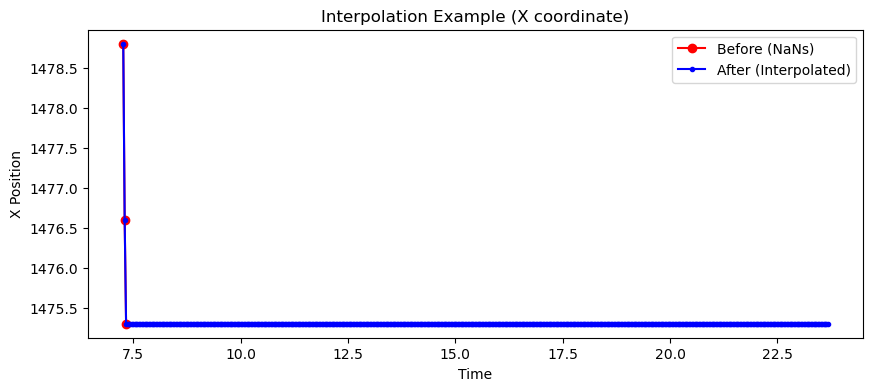

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(sample['before'].index, sample['before']['x'], 'ro-', label='Before (NaNs)')
plt.plot(sample['after']['time'], sample['after']['x'], 'b.-', label='After (Interpolated)')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.title('Interpolation Example (X coordinate)')
plt.legend()
plt.show()

## compute velocity 

In [11]:
segments_with_velocity = []

for segment_data in interpolated_segments:
    seg = segment_data['after'].copy()  # Get the interpolated data
    seg['dt'] = seg['time'].diff()      # Time difference between each row
    
    # Calculate velocity for x, y, z
    seg['velocity_x'] = seg['x'].diff() / seg['dt']
    seg['velocity_y'] = seg['y'].diff() / seg['dt']
    seg['velocity_z'] = seg['z'].diff() / seg['dt']
    
    # Drop rows with NaN (usually the first row after .diff)
    seg = seg.dropna(subset=['dt', 'velocity_x', 'velocity_y', 'velocity_z']).reset_index(drop=True)
    
    # Keep only segments with at least 3 rows
    if len(seg) >= 3:
        segments_with_velocity.append(seg)

In [12]:
print(segments_with_velocity[0][['time', 'x', 'velocity_x', 'y', 'velocity_y']].head())

    time       x  velocity_x       y  velocity_y
0  7.303  1476.6  -66.666667  2000.5   60.606061
1  7.336  1475.3  -39.393939  2001.8   39.393939
2  7.369  1475.3    0.000000  2001.8    0.000000
3  7.402  1475.3    0.000000  2001.8    0.000000
4  7.435  1475.3    0.000000  2001.8    0.000000


this means:
	•	Between time 7.270 and 7.303, the bee moved left in X direction (because velocity_x is negative) and up in Y direction (because velocity_y is positive).
 
	•	Then the movement became slower (velocity got smaller).
	•	Then it stopped completely (velocity = 0).

This shows natural movement, like a bee flying and stopping. ✅

⸻

✅ Why this looks good:

	•	Units are pixels per second — movement like 60 pixels per second is realistic.
	•	The pattern shows slowing down, not jumping or crazy values.
	•	Later, velocity becomes zero — which is perfect if the bee stayed still.

## remove unrealstic velocities 

In [13]:
clean_segments = []

for i, seg in enumerate(segments_with_velocity):
    # Find the largest absolute velocity value in x, y, or z
    max_velocity = seg[['velocity_x', 'velocity_y', 'velocity_z']].abs().max().max()

    if max_velocity < 1000:  # Keep only if all velocities are realistic
        clean_segments.append(seg)
    else:
        print(f"❌ Removed Segment {i} due to high velocity: {max_velocity:.2f} pixels/sec")

print(f"✅ Kept {len(clean_segments)} clean segments out of {len(segments_with_velocity)}")

❌ Removed Segment 10 due to high velocity: 1215.15 pixels/sec
❌ Removed Segment 25 due to high velocity: 1578.79 pixels/sec
❌ Removed Segment 26 due to high velocity: 2060.61 pixels/sec
❌ Removed Segment 32 due to high velocity: 1090.91 pixels/sec
❌ Removed Segment 38 due to high velocity: 1051.52 pixels/sec
❌ Removed Segment 39 due to high velocity: 1445.45 pixels/sec
❌ Removed Segment 79 due to high velocity: 1778.79 pixels/sec
❌ Removed Segment 85 due to high velocity: 1024.24 pixels/sec
❌ Removed Segment 96 due to high velocity: 1012.12 pixels/sec
❌ Removed Segment 102 due to high velocity: 1272.73 pixels/sec
❌ Removed Segment 133 due to high velocity: 1951.52 pixels/sec
❌ Removed Segment 158 due to high velocity: 1233.33 pixels/sec
❌ Removed Segment 204 due to high velocity: 2030.30 pixels/sec
❌ Removed Segment 207 due to high velocity: 3703.03 pixels/sec
❌ Removed Segment 229 due to high velocity: 2975.76 pixels/sec
❌ Removed Segment 230 due to high velocity: 1109.09 pixels/sec
❌

## calculate angular velocity 

In [14]:
import numpy as np

segments_with_angular_velocity = []

for i, seg in enumerate(clean_segments):
    seg = seg.copy()  # Don't modify original
    
    # 1. Get velocities
    vx = seg['velocity_x'].values
    vy = seg['velocity_y'].values
    
    # 2. Calculate direction angles
    angles = np.arctan2(vy, vx)
    
    # 3. Calculate angular velocity (change in angle over time)
    angular_velocity = np.diff(angles) / seg['dt'].values[1:]
    
    # 4. Pad the first value with NaN to match the length
    angular_velocity = np.insert(angular_velocity, 0, np.nan)
    
    # 5. Save to segment
    seg['angular_velocity'] = angular_velocity

    # Optional: Only keep if we have at least 3 valid angular velocities
    if seg['angular_velocity'].notna().sum() >= 3:
        segments_with_angular_velocity.append(seg)

print(f"✅ Calculated angular velocity for {len(segments_with_angular_velocity)} segments")

✅ Calculated angular velocity for 1048 segments


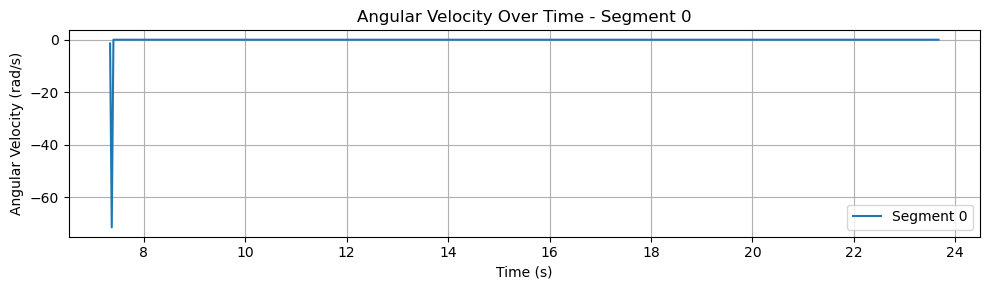

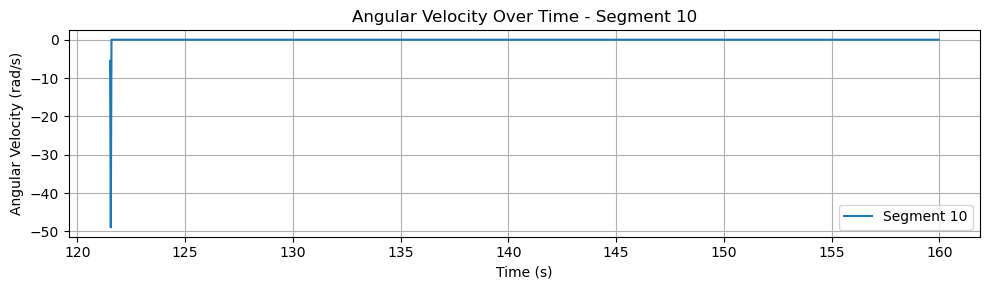

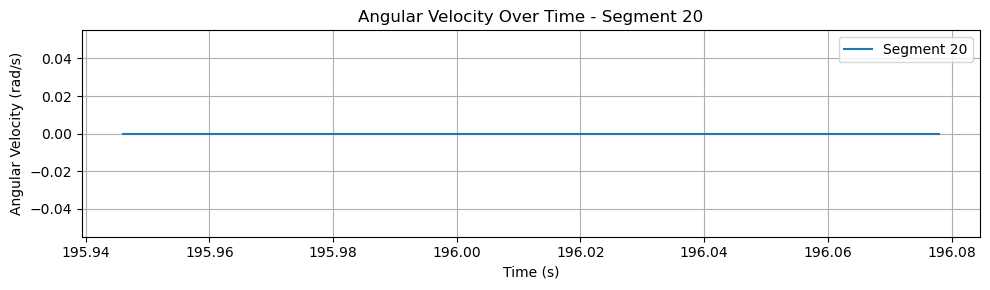

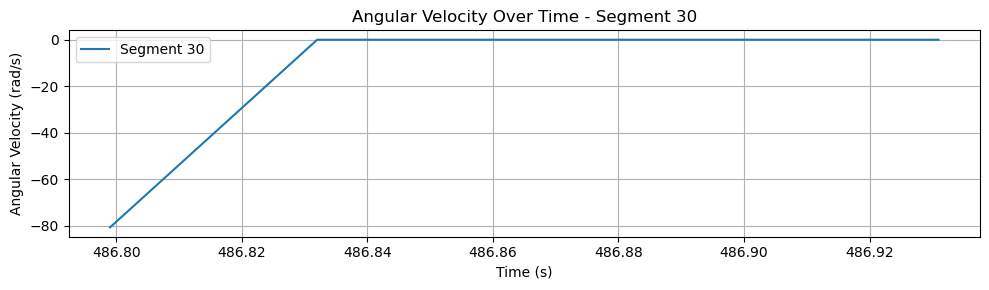

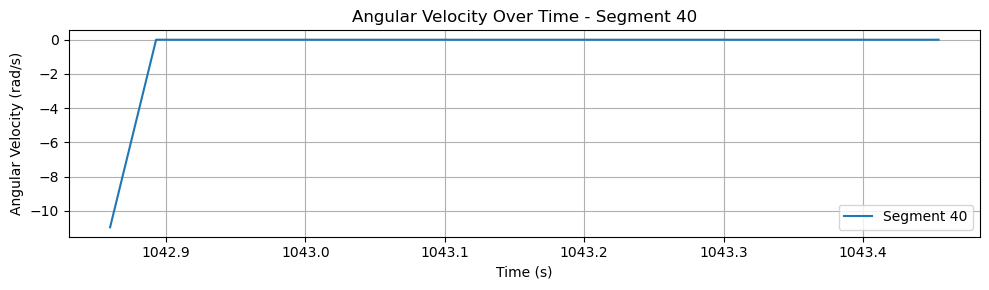

In [15]:
import matplotlib.pyplot as plt

# Choose a few sample segments to visualize (you can change the indices)
sample_indices = [0, 10, 20, 30, 40]

for idx in sample_indices:
    seg = segments_with_angular_velocity[idx]
    
    plt.figure(figsize=(10, 3))
    plt.plot(seg['time'], seg['angular_velocity'], label=f'Segment {idx}')
    plt.xlabel("Time (s)")
    plt.ylabel("Angular Velocity (rad/s)")
    plt.title(f'Angular Velocity Over Time - Segment {idx}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## extract fixed length samples

In [16]:
import numpy as np

# Parameters
window_size = 30  # number of frames (1 second)
features = ['velocity_x', 'velocity_y', 'velocity_z', 'angular_velocity']

samples = []

# Loop over all segments
for seg in segments_with_angular_velocity:
    if len(seg) < window_size:
        continue  # skip short segments

    # Convert to NumPy for fast access
    data = seg[features].values

    # Slide over the segment to extract windows
    for i in range(0, len(data) - window_size + 1):
        window = data[i:i+window_size]
        if np.isnan(window).any():
            continue  # skip if any NaNs
        samples.append(window)

# Convert to array
samples_array = np.stack(samples)  # shape: (num_samples, window_size, num_features)

# Summary
print(f"✅ Created {samples_array.shape[0]} samples")
print(f"Each sample shape: {samples_array.shape[1:]} (Timestep, Feature)")

✅ Created 162770 samples
Each sample shape: (30, 4) (Timestep, Feature)


In [17]:
import numpy as np

# Save the samples array
np.save('bee_samples.npy', samples_array)
print("✅ Saved samples to 'bee_samples.npy'")

✅ Saved samples to 'bee_samples.npy'


In [18]:
# Load from file
samples_array = np.load('bee_samples.npy')
print("✅ Loaded samples with shape:", samples_array.shape)

✅ Loaded samples with shape: (162770, 30, 4)
